# Fashion MNIST

### Aim

Classify images of different pieces of clothing.

### Dataset

Dataset obtained from the [Zalando Fashion MNIST repository](https://github.com/zalandoresearch/fashion-mnist) on Github.

### Information about the dataset

The training set contains **60,000** examples and the test set contains **10,000** examples. Each example is a **28x28 grayscale image**, and has an associated label from **10 classes**.

Image sizes and train-test split structure are the same as the ones in the original MNIST dataset.

### Imports

In [29]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.python.framework import ops

%matplotlib inline
%config InlineBackend.figure_format='retina'

# Import Fashion MNIST data with one-hot encoding
from tensorflow.examples.tutorials.mnist import input_data
fashion_mnist = input_data.read_data_sets('input/data', one_hot=True)

Extracting input/data/train-images-idx3-ubyte.gz
Extracting input/data/train-labels-idx1-ubyte.gz
Extracting input/data/t10k-images-idx3-ubyte.gz
Extracting input/data/t10k-labels-idx1-ubyte.gz


### Data format

Now that we've imported our dataset, we can take a look at what format our data is in, and check the shapes of each example image and label array.

In [9]:
# Dataset type
type(fashion_mnist)

tensorflow.contrib.learn.python.learn.datasets.base.Datasets

In [10]:
# Shapes of training set and test set
print("Training set (images) shape: {shape}".format(shape=fashion_mnist.train.images.shape))
print("Training set (labels) shape: {shape}".format(shape=fashion_mnist.train.labels.shape))
print("Test set (images) shape: {shape}".format(shape=fashion_mnist.test.images.shape))
print("Test set (labels) shape: {shape}".format(shape=fashion_mnist.test.labels.shape))

Training set (images) shape: (55000, 784)
Training set (labels) shape: (55000, 10)
Test set (images) shape: (10000, 784)
Test set (labels) shape: (10000, 10)


In [11]:
# Check that images are arrays
type(fashion_mnist.train.images)

numpy.ndarray

In [13]:
# Shape of first image in training set
fashion_mnist.train.images[0].shape

(784,)

In [14]:
# Format of labels
fashion_mnist.train.labels[0]

array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

### Target classes

The target class labels in the dataset are arrays, and the index of the 1 signifies the piece of clothing to which the image corresponds.

Let's create a dictionary of these integer labels with their associated text labels. 

**Note: ** Mapping between labels and text taken from the original [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) repository.

In [33]:
# Dictionary of labels
label_dict = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

y = 2 (Pullover)


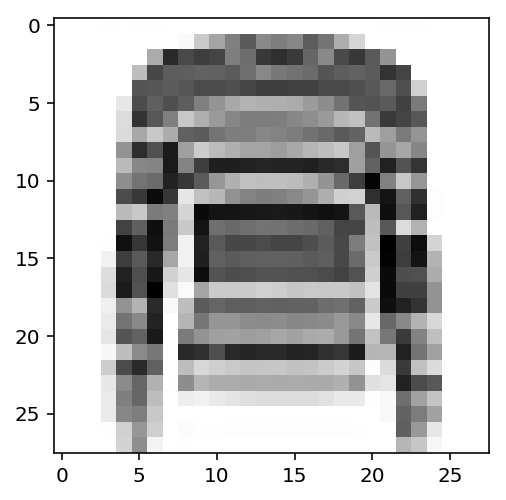

In [38]:
# Get random image and associated label
sample = fashion_mnist.train.images[47].reshape(28,28)
sample_label = np.where(fashion_mnist.train.labels[47] == 1)[0][0]

# Show image and label
print("y = {label_index} ({label})".format(label_index=sample_label, label=label_dict[sample_label]))
plt.imshow(sample, cmap='Greys')

## Building our neural network

### Setting network parameters

First, let's set some parameters for our network. This includes information about the number of units in each layer, shape of inputs, number of output classes, and number of examples.

In [15]:
# Network parameters
n_hidden_1 = 256 # Units in first hidden layer
n_hidden_2 = 256 # Units in second hidden layer
n_input = 784 # Fashion MNIST data input (img shape: 28*28)
n_classes = 10 # Fashion MNIST total classes (0-9 digits)
n_samples = fashion_mnist.train.num_examples

### Creating Placeholders

Next, let's set up a function that creates placeholders for `X` and `Y`, using which we will later pass training data while running our network.

In [16]:
# Create placeholders
def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of an image vector (num_px * num_px = 64 * 64 * 3 = 12288)
    n_y -- scalar, number of classes (from 0 to 5, so -> 6)
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"
    
    Tips:
    - You will use None because it let's us be flexible on the number of examples you will for the placeholders.
      In fact, the number of examples during test/train is different.
    """
    
    X = tf.placeholder(tf.float32, [n_x, None], name="X")
    Y = tf.placeholder(tf.float32, [n_y, None], name="Y")
    
    return X, Y

In [17]:
# Test create_placeholders()
X, Y = create_placeholders(n_input, n_classes)

print("Shape of X: {shape}".format(shape=X.shape))
print("Shape of Y: {shape}".format(shape=Y.shape))

Shape of X: (784, ?)
Shape of Y: (10, ?)


### Initializing parameters

After creating placeholders, we will have to initialize the weights and biases for each layer in our 3-layer neural network.

This implementation uses the **Xavier initialization** for weights, and a **Zero initialization** for biases.

In [18]:
def initialize_parameters():
    """
    Initializes parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [n_hidden_1, n_input]
                        b1 : [n_hidden_1, 1]
                        W2 : [n_hidden_2, n_hidden_1]
                        b2 : [n_hidden_2, 1]
                        W3 : [n_classes, n_hidden_2]
                        b3 : [n_classes, 1]
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    
    # Set random seed for reproducibility
    tf.set_random_seed(42)
    
    # Initialize weights and biases for each layer
    W1 = tf.get_variable("W1", [n_hidden_1, n_input], initializer=tf.contrib.layers.xavier_initializer(seed=42))
    b1 = tf.get_variable("b1", [n_hidden_1, 1], initializer=tf.zeros_initializer())
    
    W2 = tf.get_variable("W2", [n_hidden_2, n_hidden_1], initializer=tf.contrib.layers.xavier_initializer(seed=42))
    b2 = tf.get_variable("b2", [n_hidden_2, 1], initializer=tf.zeros_initializer())
    
    W3 = tf.get_variable("W3", [n_classes, n_hidden_2], initializer=tf.contrib.layers.xavier_initializer(seed=42))
    b3 = tf.get_variable("b3", [n_classes, 1], initializer=tf.zeros_initializer())
    
    # Store initializations as a dictionary of parameters
    parameters = {
        "W1": W1,
        "b1": b1,
        "W2": W2,
        "b2": b2,
        "W3": W3,
        "b3": b3
    }
    
    return parameters

In [19]:
# Test initialize_parameters()
tf.reset_default_graph()
with tf.Session() as sess:
    parameters = initialize_parameters()
    print("W1 = " + str(parameters["W1"]))
    print("b1 = " + str(parameters["b1"]))
    print("W2 = " + str(parameters["W2"]))
    print("b2 = " + str(parameters["b2"]))

W1 = <tf.Variable 'W1:0' shape=(256, 784) dtype=float32_ref>
b1 = <tf.Variable 'b1:0' shape=(256, 1) dtype=float32_ref>
W2 = <tf.Variable 'W2:0' shape=(256, 256) dtype=float32_ref>
b2 = <tf.Variable 'b2:0' shape=(256, 1) dtype=float32_ref>


As expected, our parameters haven't been initialized yet.

### Model

`LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX`

`LINEAR`: $$ Z^{[l]} = W^{[l]}A^{[l-1]} + b $$

`RELU`: $$ A^{[l]} = max ( 0, Z^{[l]} ) $$

### Forward Propagation

Next, let's implement forward propagation. This function will take in a dictionary of parameters and the input (`X`), to complete the forward pass. It will return the output from the last layer.

In [21]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve parameters from dictionary
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    # Carry out forward propagation      # Numpy equivalents:
    Z1 = tf.add(tf.matmul(W1,X), b1)     # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                  # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2,A1), b2)    # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                  # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3,A2), b3)    # Z3 = np.dot(W3,Z2) + b3
    
    return Z3

In [22]:
# Test forward_propagation()
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(n_input, n_classes)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    print("Z3 = " + str(Z3))

Z3 = Tensor("Add_2:0", shape=(10, ?), dtype=float32)


### Compute Cost

Next, let's create a function which computes the cost based on the difference between our outputs (`Z3`) and the correct labels (`Y`).

`SOFTMAX: `

`tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(...))` 

In [23]:
def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (10, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    # Get logits (predictions) and labels
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    # Compute cost
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    
    return cost

In [24]:
# Test compute_cost()
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(n_input, n_classes)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    print("cost = " + str(cost))

cost = Tensor("Mean:0", shape=(), dtype=float32)


### Backpropagation

We will use the Adam optimizer in this implementation.

`optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)`


### Building the model

Finally, let's combine our previously created functions into one single function called `model()` and run our network.

In [35]:
def model(train, test, learning_rate=0.0001, num_epochs=16, minibatch_size=32, print_cost=True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    train -- training set
    test -- test set
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every epoch
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    # Ensure that model can be rerun without overwriting tf variables
    ops.reset_default_graph()
    # For reproducibility
    tf.set_random_seed(42)
    seed = 42
    # Get input and output shapes
    (n_x, m) = train.images.T.shape
    n_y = train.labels.T.shape[0]
    
    costs = []
    
    # Create placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)
    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation
    Z3 = forward_propagation(X, parameters)
    # Cost function
    cost = compute_cost(Z3, Y)
    # Backpropagation (using Adam optimizer)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    
    # Initialize variables
    init = tf.global_variables_initializer()
    
    # Start session to compute Tensorflow graph
    with tf.Session() as sess:
        
        # Run initialization
        sess.run(init)
        
        # Training loop
        for epoch in range(num_epochs):
            
            epoch_cost = 0.
            num_minibatches = int(m / minibatch_size)
            seed = seed + 1
            
            for i in range(num_minibatches):
                
                # Get next batch of training data and labels
                minibatch_X, minibatch_Y = train.next_batch(minibatch_size)
                
                # Execute optimizer and cost function
                _, minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X.T, Y: minibatch_Y.T})
                
                # Update epoch cost
                epoch_cost += minibatch_cost / num_minibatches
                
            # Print the cost every epoch
            if print_cost == True:
                print("Cost after epoch {epoch_num}: {cost}".format(epoch_num=epoch, cost=epoch_cost))
                costs.append(epoch_cost)
        
        # Plot costs
        plt.figure(figsize=(16,5))
        plt.plot(np.squeeze(costs), color='#C24F6F')
        plt.xlim(0, num_epochs-1)
        plt.ylabel("cost")
        plt.xlabel("iterations")
        plt.title("learning rate = {rate}".format(rate=learning_rate))
        plt.show()
        
        # Save parameters
        parameters = sess.run(parameters)
        print("Parameters have been trained!")
        
        # Calculate correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))
        
        # Calculate accuracy on test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        
        print ("Train Accuracy:", accuracy.eval({X: train.images.T, Y: train.labels.T}))
        print ("Test Accuracy:", accuracy.eval({X: test.images.T, Y: test.labels.T}))
        
        return parameters

Cost after epoch 0: 0.6063177797409924
Cost after epoch 1: 0.42006529277413956
Cost after epoch 2: 0.37942108499781774
Cost after epoch 3: 0.3538064636610992
Cost after epoch 4: 0.3353833645881438
Cost after epoch 5: 0.31699288178916124
Cost after epoch 6: 0.30358147003164243
Cost after epoch 7: 0.2896183801769378
Cost after epoch 8: 0.2814889423965503
Cost after epoch 9: 0.2718670091020403
Cost after epoch 10: 0.26187946724817107
Cost after epoch 11: 0.2540142726742936
Cost after epoch 12: 0.24520070983662906
Cost after epoch 13: 0.23841651896615462
Cost after epoch 14: 0.2303414097114337
Cost after epoch 15: 0.22385913627579948


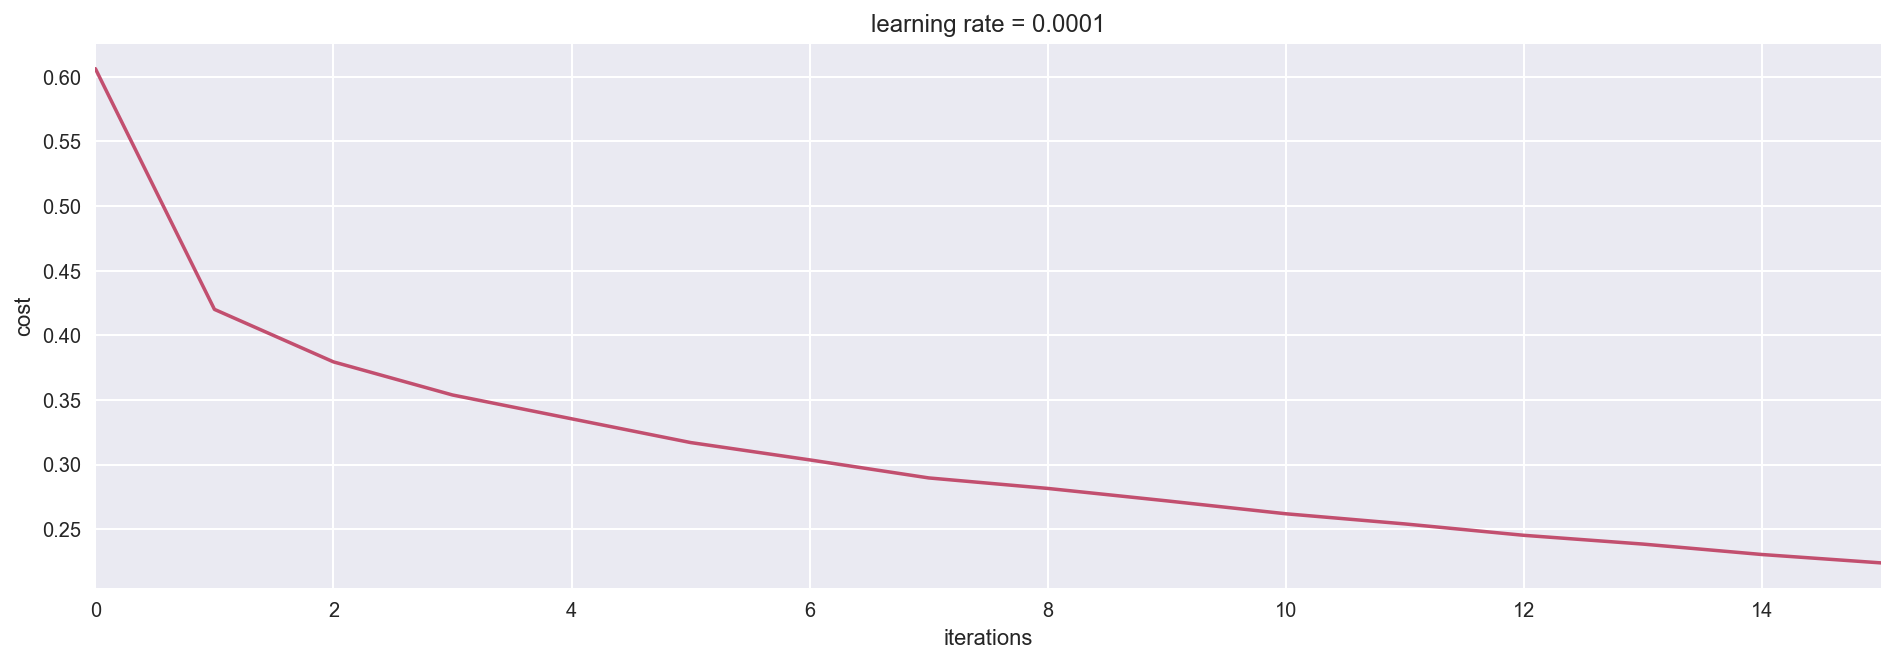

Parameters have been trained!
Train Accuracy: 0.920455
Test Accuracy: 0.8957


In [36]:
# Running our model
train = fashion_mnist.train
test = fashion_mnist.test

parameters = model(train, test)